In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
from __future__ import print_function

import tensorflow as tf

from keras.layers import Flatten, Dense, Reshape
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras import losses
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import models
from keras import layers
import keras

from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
from mpl_toolkits.mplot3d import Axes3D



import numpy as np
import pandas as pd
import sys
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
#from keract import get_activations
import numpy as np 
import pandas as pd 
from tensorflow import keras
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras import losses
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
def tf_print(op, tensors, message=""):
    def print_message(x):
        #print(x)
        sys.stdout.write("\n DEBUG: " + message + " %s\n" % x)
        return x

    prints = [tf.compat.v1.py_func(print_message, [tensor], tensor.dtype) for tensor in tensors]
    with tf.control_dependencies(prints):
        op = tf.identity(op)
    return op

def tf_print_2(tensor, tensors):
    def print_message(x):
        #print(x)
        message = ""
        sys.stdout.write("DEBUG: " + message + " %s" % x)
        return x

    #prints = [tf.compat.v1.py_func(print_message, [tensor], tensor.dtype) for tensor in tensors]
    prints = [tf.compat.v1.py_func(print_message, [tensors], tensor.dtype)]
    with tf.control_dependencies(prints):
        tensor = tf.identity(tensor)
    return tensor


def pairwise_dist(A):
    # Taken frmo https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    #A = tf_print(A, [tf.reduce_sum(A)], message="A is")
    r = tf.reduce_sum(A*A, 1)
    #r = tf_print(r, [tf.reduce_sum(r)], message="r is")
    r = tf.reshape(r, [-1, 1])
    D = tf.maximum(r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r), 1e-7)
    D = tf.sqrt(D)
    return D

def dist_corr(X, Y):
    n = tf.cast(tf.shape(X)[0], tf.float32)
    a = pairwise_dist(X)
    b = pairwise_dist(Y)
    A = a - tf.reduce_mean(a, axis=1) - tf.expand_dims(tf.reduce_mean(a, axis=0), axis=1) + tf.reduce_mean(a)
    B = b - tf.reduce_mean(b, axis=1) - tf.expand_dims(tf.reduce_mean(b, axis=0), axis=1) + tf.reduce_mean(b)
    dCovXY = tf.sqrt(tf.reduce_sum(A*B) / (n ** 2))
    dVarXX = tf.sqrt(tf.reduce_sum(A*A) / (n ** 2))
    dVarYY = tf.sqrt(tf.reduce_sum(B*B) / (n ** 2))
    
    dCorXY = dCovXY / tf.sqrt(dVarXX * dVarYY)
    return dCorXY

def custom_loss1(y_true,y_pred):
    #y_pred = tf_print(y_pred, [tf.reduce_sum(y_pred)], message="y_pred is")
    dcor = dist_corr(y_true,y_pred)
    #dcor = tf_print(dcor, [tf.reduce_sum(dcor)], message="dcor is")
    return dcor

def custom_loss2(y_true,y_pred):
    #y_pred = tf_print(y_pred, [tf.reduce_sum(y_pred)], message="y_pred is")
    recon_loss = losses.categorical_crossentropy(y_true, y_pred)
    return recon_loss

In [4]:
alpha1, alpha2 = 1000., 0.1
stage_num, block_num = 2, 1
experiment_name = "cifar10_{}_{}_{}_{}".format(alpha1, alpha2, stage_num, block_num)

In [5]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

n = 3

# Computed depth from supplied model parameter n
depth = n * 9 + 2

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_trainRaw = x_train
x_testRaw = x_test
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-4
    if epoch > 180:
        lr = 1e-6
    elif epoch > 160:
        lr = 7e-6
    elif epoch > 120:
        lr = 2e-5
    elif epoch > 80:
        lr = 8e-5
    #print('Learning rate: ', lr)
    return lr

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            if stage_num == stage and block_num == res_block:
                before_flatten_dims = x.get_shape().as_list()[1:]
                split_layer = Flatten(name='split_layer')
                split_layer_output = split_layer(x)
                x = Reshape(before_flatten_dims)(split_layer_output)
                print(before_flatten_dims)

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal',
                    name='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=[split_layer_output, outputs])
    #model = Model(inputs=inputs, outputs=[outputs])
    return model


model = resnet_v2(input_shape=input_shape, depth=depth)

[8, 8, 256]


W1116 02:17:11.867964 140025268062016 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4074: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [6]:
model.compile(loss={'split_layer': custom_loss1, 'softmax': custom_loss2},
              loss_weights={'split_layer': alpha1, 'softmax': alpha2},
              optimizer=Adam(lr=lr_schedule(0)),
              metrics={'softmax':'accuracy'})
#model.compile(loss=custom_loss2, optimizer=Adam(lr=lr_schedule(0)),
#              metrics=['accuracy'])
#model.summary()
#print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), '../saved_models')
model_name = '%s_model.{epoch:03d}.h5' % experiment_name
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-5)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
x_train_flattened = x_train.reshape(50000, 32*32*3)
x_test_flattened = x_test.reshape(10000, 32*32*3)

history = model.fit(x_train, [x_train_flattened, y_train],
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, [x_test_flattened, y_test]),
          shuffle=True,
          callbacks=callbacks,
          verbose=2)


W1116 02:21:45.219141 140025268062016 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1116 02:21:53.105401 140025268062016 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 40s - loss: 423.1403 - split_layer_loss: 0.4223 - softmax_loss: 2.1687 - softmax_accuracy: 0.2133 - val_loss: 383.8076 - val_split_layer_loss: 0.3862 - val_softmax_loss: 2.1135 - val_softmax_accuracy: 0.2117
Epoch 2/100
 - 32s - loss: 299.7992 - split_layer_loss: 0.2990 - softmax_loss: 2.0241 - softmax_accuracy: 0.2636 - val_loss: 287.2895 - val_split_layer_loss: 0.2898 - val_softmax_loss: 2.0317 - val_softmax_accuracy: 0.2651
Epoch 3/100
 - 32s - loss: 272.4865 - split_layer_loss: 0.2718 - softmax_loss: 1.9693 - softmax_accuracy: 0.2808 - val_loss: 268.3016 - val_split_layer_loss: 0.2707 - val_softmax_loss: 2.1230 - val_softmax_accuracy: 0.2196
Epoch 4/100
 - 33s - loss: 261.2557 - split_layer_loss: 0.2606 - softmax_loss: 1.9359 - softmax_accuracy: 0.2934 - val_loss: 260.4412 - val_split_layer_loss: 0.2629 - val_softmax_loss: 1.9569 - val_softmax_accuracy: 0.2870
Epoch 5/100
 - 32s - loss: 252.1701 - split_layer_loss: 0.

KeyboardInterrupt: 

In [12]:
history = model.fit(x_train, [x_train_flattened, y_train],
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, [x_test_flattened, y_test]),
          shuffle=True,
          callbacks=callbacks,
          verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 32s - loss: 226.5416 - split_layer_loss: 0.2257 - softmax_loss: 1.7478 - softmax_accuracy: 0.3577 - val_loss: 231.3057 - val_split_layer_loss: 0.2340 - val_softmax_loss: 1.8649 - val_softmax_accuracy: 0.3097
Epoch 2/100
 - 31s - loss: 226.7428 - split_layer_loss: 0.2259 - softmax_loss: 1.7422 - softmax_accuracy: 0.3580 - val_loss: 237.8123 - val_split_layer_loss: 0.2401 - val_softmax_loss: 2.2932 - val_softmax_accuracy: 0.2250
Epoch 3/100
 - 30s - loss: 226.6010 - split_layer_loss: 0.2257 - softmax_loss: 1.7368 - softmax_accuracy: 0.3613 - val_loss: 229.7404 - val_split_layer_loss: 0.2322 - val_softmax_loss: 1.8368 - val_softmax_accuracy: 0.3183
Epoch 4/100
 - 30s - loss: 225.7521 - split_layer_loss: 0.2249 - softmax_loss: 1.7377 - softmax_accuracy: 0.3602 - val_loss: 230.0138 - val_split_layer_loss: 0.2325 - val_softmax_loss: 2.1976 - val_softmax_accuracy: 0.2412
Epoch 5/100
 - 32s - loss: 223.3505 - split_layer_loss: 0.

In [7]:
x_test_encoded = model.predict(x_test)

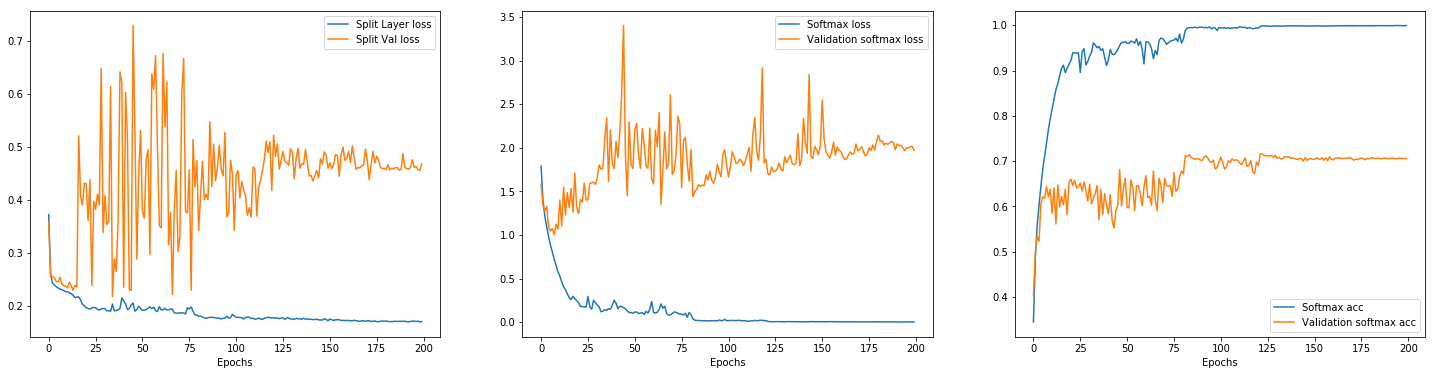

In [9]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(25, 6))
    
    axes[0].plot(history.history['split_layer_loss'], label='Split Layer loss')
    axes[0].plot(history.history['val_split_layer_loss'], label='Split Val loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['softmax_loss'], label='Softmax loss')
    axes[1].plot(history.history['val_softmax_loss'], label='Validation softmax loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['softmax_accuracy'], label='Softmax acc')
    axes[2].plot(history.history['val_softmax_accuracy'], label='Validation softmax acc')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

plot_train_history(history)

(10000, 10)

In [10]:
experiment_name

'cifar10_1000.0_0.1_2_1'

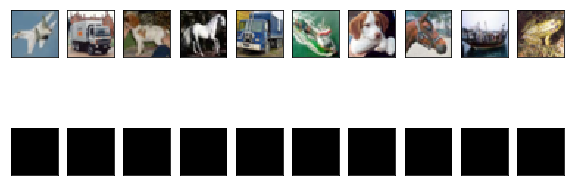

In [13]:
#test raw vs smash
n = 20
plt.figure(figsize=(20, 4))
for i in range(10,20):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    #plt.imshow((x_test[i] * 255).astype(np.int64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_encoded[0][i].reshape(16, 16, 3))
    #plt.imshow((x_test_encoded[0][i].reshape(32, 32, 3) * 255).astype(np.int64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [11]:
out_dir = '/tf/datasets/{}/output/'.format(experiment_name)
inp_dir = '/tf/datasets/{}/input/'.format(experiment_name)
os.makedirs(out_dir)
os.makedirs(inp_dir)
import matplotlib
for i in range(10000):
    #np.save('rawCifar10_baseline/'+str(i), x_test[i],allow_pickle = True)
    #np.save('noSmashCifar10_baseline/'+str(i), x_test_encoded[0][i].reshape(32, 32, 3),allow_pickle = True)
    np.save('{}/{}'.format(out_dir, i), x_test_encoded[0][i].reshape(8, 8, 256),allow_pickle = True)
    np.save('{}/{}'.format(inp_dir, i), x_testRaw[i].reshape(32, 32, 3),allow_pickle = True)
    
    #matplotlib.image.imsave('rawCifar10/'+str(i)+'.png', x_test[i])
    #matplotlib.image.imsave('smashCifar10/'+str(i)+'.png', x_test_encoded[0][i].reshape(32, 32, 3))

In [16]:
import pickle
with open('/tf/datasets/{}/trainHistoryDict'.format(experiment_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
with open('/tf/datasets/{}/trainHistoryDict2'.format(experiment_name), 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)


In [ ]:
#train raw vs smash
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_encoded[0][i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()